<a href="https://colab.research.google.com/github/EjbejaranosAI/AI_trends_2023/blob/main/MBM_AI_for__analysis_of_brain_image_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI/ML for the analysis of brain imaging data.
## MBM (Minds, brains and machines)
## Author: Edison Jair Bejarano Sepulveda

### Quantitative susceptibility mapping - QSM DATA from 2018 reconstruction challenge

##### *Download data*

In [1]:
# Downloading data
!wget -nc http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
!unzip -uo 20170327_qsm2016_recon_challenge.zip

--2023-06-09 04:41:04--  http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
Resolving www.neuroimaging.at (www.neuroimaging.at)... 81.19.159.35
Connecting to www.neuroimaging.at (www.neuroimaging.at)|81.19.159.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244982259 (234M) [application/zip]
Saving to: ‘20170327_qsm2016_recon_challenge.zip’

20170327_qsm2016_re 100%[===================>] 233.63M   104MB/s    in 2.3s    

2023-06-09 04:41:06 (104 MB/s) - ‘20170327_qsm2016_recon_challenge.zip’ saved [244982259/244982259]

Archive:  20170327_qsm2016_recon_challenge.zip
   creating: 20170327_qsm2016_recon_challenge/
   creating: 20170327_qsm2016_recon_challenge/data/
  inflating: 20170327_qsm2016_recon_challenge/data/chi_33.mat  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_33.nii.gz  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_cosmos.mat  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_cosmos.nii.gz  
  infla

##### *Libraries*

In [2]:
!pip install -q tensorflow==2.0.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-alpha0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==2.0.0-alpha0


In [3]:
# Importing libraries
import os
import pickle
import numpy as np
import nibabel as nib
from tqdm import tqdm
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import transforms

import tensorflow as tf
import tensorflow.keras.losses as losses
import tensorflow.keras.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

##### *Utils functions*

In [4]:
# Utils functions

#--------------------------#
# Plot view slices brain 3D
#--------------------------#
def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title=''):
    fig = plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(131)
    image = np.take(image_3d, slice_nbr, 2)
    plt.imshow(image, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Axial')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    plt.subplot(132)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Coronal')
    plt.xlabel('X-axis')
    plt.ylabel('Z-axis')
    
    plt.subplot(133)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Sagittal')
    plt.xlabel('Y-axis')
    plt.ylabel('Z-axis')
    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Intensity', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

#--------------------------#
#       Random size 
#--------------------------#
def creating_random_size(min_size, max_size):
  random_size = np.random.randint(low = min_size, high = max_size)
  return random_size



#--------------------------#
# Susceptibility simulation
#--------------------------#
def simulate_susceptibility_sources(simulation_dim = 160,
                                    rectangles_total = 100, 
                                    spheres_total = 80, 
                                    sus_std = 1,
                                    shape_size_min_factor= 0.01,
                                    shape_size_max_factor = 0.5):
  
  temp_sources = np.zeros((simulation_dim, simulation_dim, simulation_dim))

  for shapes in range(rectangles_total):
    shrink_factor = 1/((shapes/rectangles_total+1))
    shape_size_min = np.floor(simulation_dim * shrink_factor * shape_size_min_factor)
    shape_size_max = np.floor(simulation_dim * shrink_factor * shape_size_max_factor)
    print(f"\n ------- Shape Min size: {shape_size_min} ------- \n")
    print(f"\n ------- Shape Max size: {shape_size_max} ------- \n")

    susceptibility_value = np.random.normal(loc=0.0, scale=sus_std)
    # Creating random sizes
    random_sizex = creating_random_size(shape_size_min,shape_size_max)
    random_sizey = creating_random_size(shape_size_min,shape_size_max)
    random_sizez = creating_random_size(shape_size_min,shape_size_max)
    # Getting axis positions
    x_pos = np.random.randint(simulation_dim)
    y_pos = np.random.randint(simulation_dim)
    z_pos = np.random.randint(simulation_dim)

    x_pos_max = x_pos + random_sizex
    if x_pos_max >= simulation_dim:
      x_pos_max = simulation_dim

    y_pos_max = y_pos + random_sizey
    if y_pos_max >= simulation_dim:
      y_pos_max = simulation_dim 

    z_pos_max = z_pos + random_sizez
    if z_pos_max >= simulation_dim:
      z_pos_max = simulation_dim

    temp_sources[x_pos:x_pos_max, y_pos:y_pos_max, z_pos:z_pos_max] = susceptibility_value

  return temp_sources

import numpy as np



#--------------------------#
#     Dipole kernel 3D
#--------------------------#
def create_dipole_kernel_3D(data_shape, voxel_size, b_vec):
    # Calculate the field of view
    fov = np.array(data_shape) * np.array(voxel_size)
    
    # Generate the x, y, and z coordinates of the image grid and
    # Create a meshgrid of the x, y, and z coordinates
    ry, rx, rz = np.meshgrid(np.arange(-data_shape[1] // 2, data_shape[1] // 2),
                          np.arange(-data_shape[0] // 2, data_shape[0] // 2),
                          np.arange(-data_shape[2] // 2, data_shape[2] // 2))
    
    # Normalize the x, y, and z coordinates by the field of view
    rx, ry, rz = rx / fov[0], ry / fov[1], rz / fov[2]
    
    # Calculate the squared distance from the origin
    sq_dist = rx ** 2 + ry ** 2 + rz ** 2
    sq_dist[sq_dist == 0] = 1e-6
    
    # Calculate the dipole kernel
    d2 = ((b_vec[0] * rx + b_vec[1] * ry + b_vec[2] * rz) ** 2) / sq_dist
    kernel = (1/3 - d2)
    
    return kernel


#--------------------------------------#
#   Forward convolution with padding
#--------------------------------------#
def simulate_mri_tissue_phase(sample, padding=20):
    # Pad the sample to avoid wrap-around at the edges
    padded_sample = np.pad(sample, pad_width=padding, mode='constant')

    # Scaling factor for Fourier transform normalization
    scaling = np.sqrt(padded_sample.size)
    
    # Perform Fourier transform of the padded sample
    sample_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(padded_sample))) / scaling

    # Generate a 3D dipole kernel
    dipole_kernel = create_dipole_kernel_3D(padded_sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    # Multiply the Fourier transform of the sample by the dipole kernel
    sample_fft_conv = sample_fft * dipole_kernel

    # Perform inverse Fourier transform and rescale by the scaling factor
    tissue_phase_unscaled = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(sample_fft_conv)))
    tissue_phase = np.real(tissue_phase_unscaled * scaling)

    # Crop the padded regions to match the original sample size
    tissue_phase_cropped = tissue_phase[padding:-padding, padding:-padding, padding:-padding]

    return tissue_phase_cropped


#--------------------------------------#
#     Forward convolution no padding
#--------------------------------------#
def simulate_mri_tissue_phase_no_padding(sample):
    # Scaling factor for Fourier transform normalization
    scaling = np.sqrt(sample.size)
    
    # Perform Fourier transform of the sample
    sample_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(sample))) / scaling

    # Generate a 3D dipole kernel
    dipole_kernel = create_dipole_kernel_3D(sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    # Multiply the Fourier transform of the sample by the dipole kernel
    sample_fft_conv = sample_fft * dipole_kernel

    # Perform inverse Fourier transform and rescale by the scaling factor
    tissue_phase = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(sample_fft_conv)))
    tissue_phase = np.real(tissue_phase * scaling)

    return tissue_phase


In [5]:
#--------------------------------------#
#     Creating batches for data
#--------------------------------------#
def create_batch(dimension, patch_idx, gt_full, fw_full):
    # Get the dimensions of the ground truth data
    x_max, y_max, z_max = gt_full.shape

    # Generate random indices for selecting the patch
    random_indices = np.random.choice(x_max - dimension, 3)
    randomX, randomY, randomZ = random_indices

    # Extract the patch using tuple indexing
    gt_patch = gt_full[randomX:randomX + dimension, randomY:randomY + dimension, randomZ:randomZ + dimension]
    fw_patch = fw_full[randomX:randomX + dimension, randomY:randomY + dimension, randomZ:randomZ + dimension]

    # Return the extracted patches
    return gt_patch, fw_patch

##### Images exploration by views

<ipython-input-6-b42306d4fe86>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
<ipython-input-6-b42306d4fe86>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


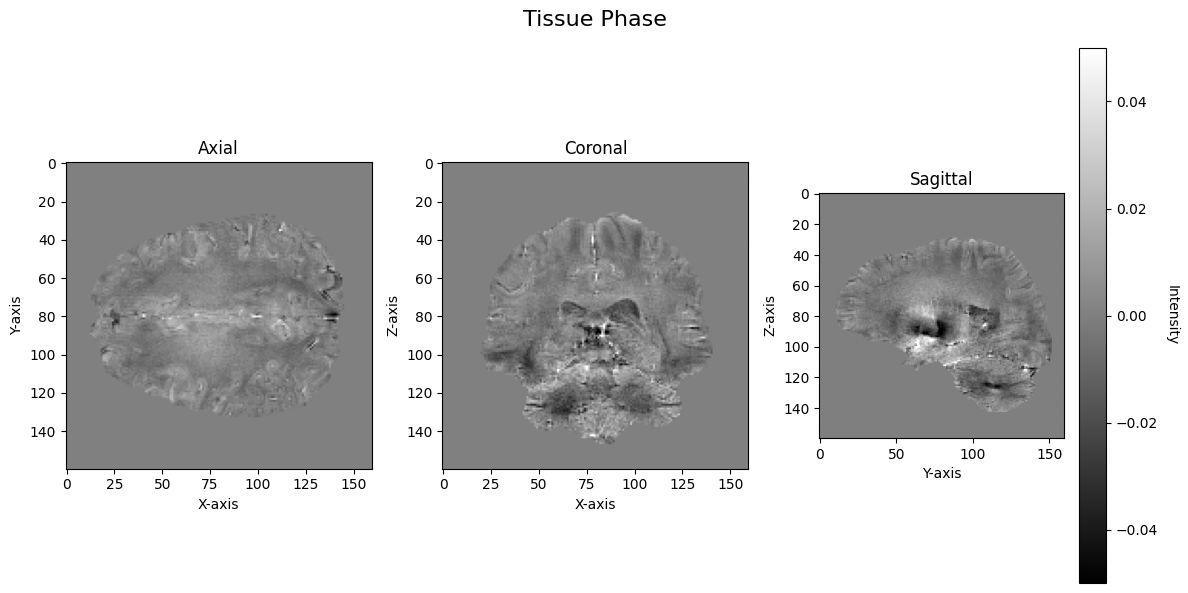

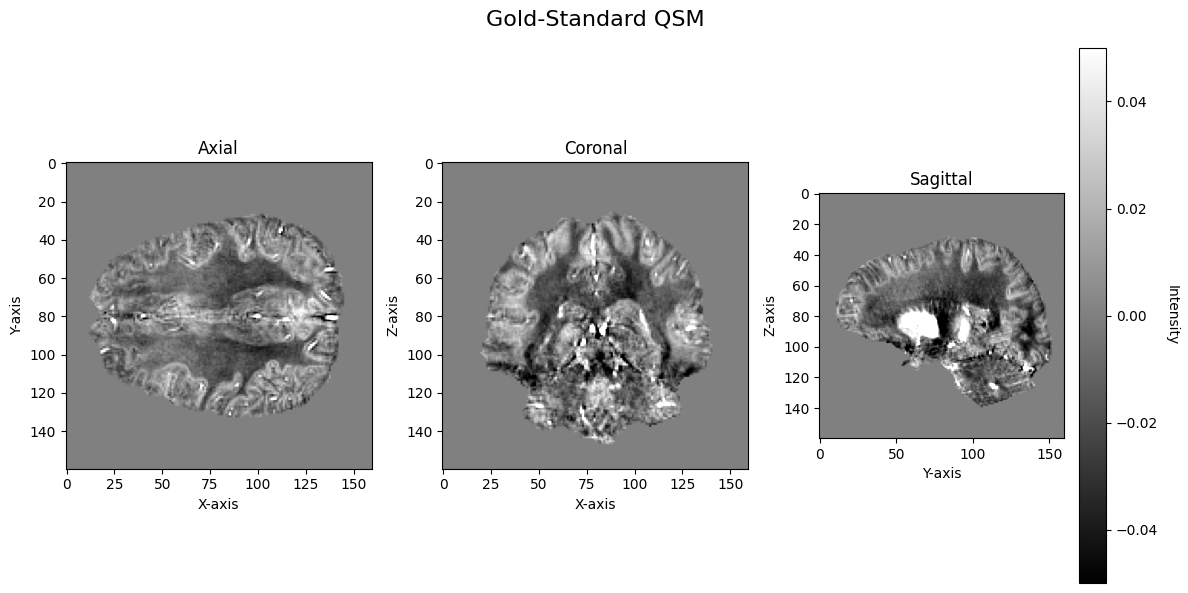

In [6]:
# Loading images by nib library
tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


view_slices_3d(tissue_phase_brain, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Tissue Phase')
view_slices_3d(gold_standard_qsm, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Gold-Standard QSM') 

##### *Simulation of susceptibility distribution*


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 160.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 157.0 ------- 


 ------- Shape 

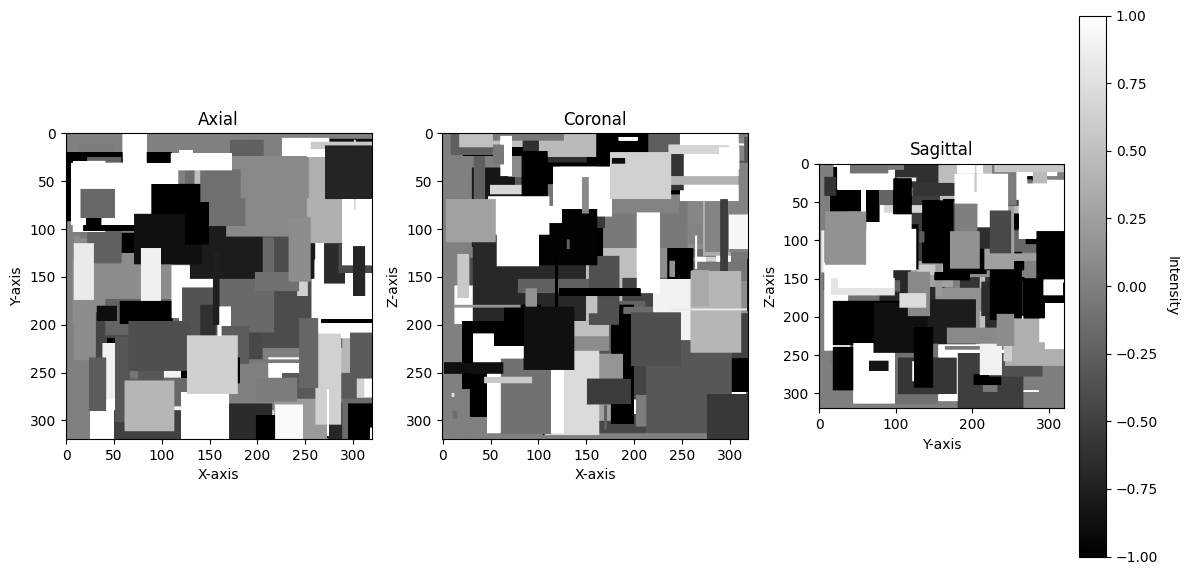

In [7]:
# sim_gt_full = simulated_ground_truth
sim_gt_full = simulate_susceptibility_sources(simulation_dim = 320, rectangles_total = 800, spheres_total = 80,)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

##### *Convolve susceptibility distribution with dipole kernel to yield tissue phase* 


Dipole Kernel: The code generates a 3D dipole kernel using the generate_3d_dipole_kernel function. This kernel represents the response of a magnetic dipole in a magnetic resonance imaging (MRI) system. It is used to model the interaction between the sample and the imaging system.

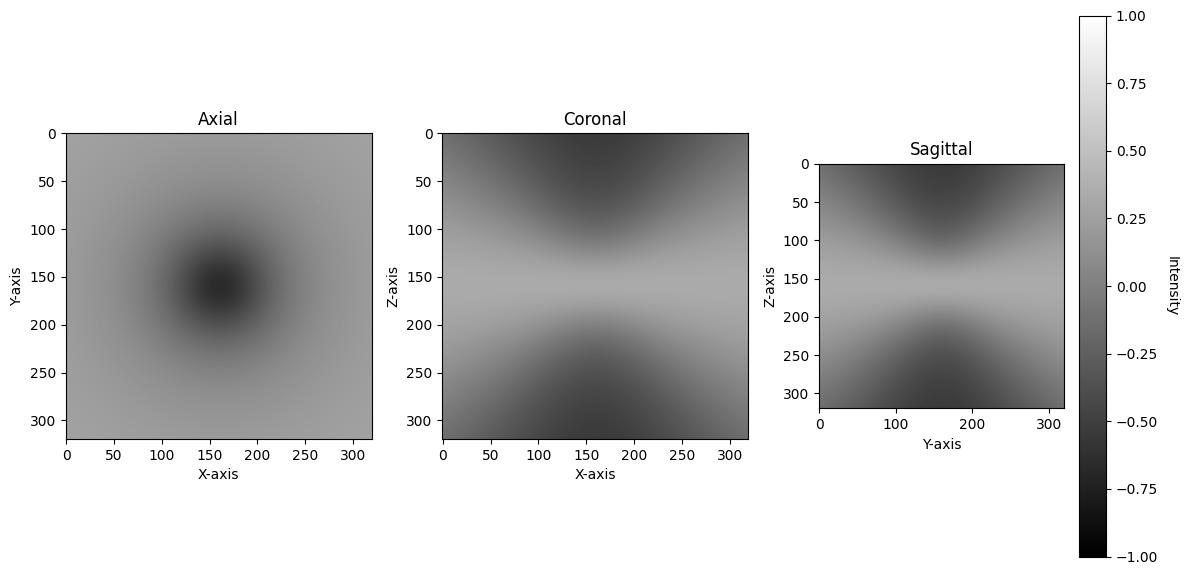

In [8]:
dipole_kernel3d = create_dipole_kernel_3D(sim_gt_full.shape, voxel_size=1, b_vec=[0, 0, 1])
view_slices_3d(dipole_kernel3d, slice_nbr=100, vmin=-1, vmax=1)

- **Fourier Transform:** The code uses the np.fft.fftn function to compute the N-dimensional Fast Fourier Transform (FFT) of the input sample. The np.fft.fftshift function is used to shift the zero-frequency component to the center of the spectrum. This is a common step in Fourier analysis to obtain a more intuitive representation of the data.

- **Inverse Fourier Transform:** The code uses the np.fft.ifftn function to compute the N-dimensional Inverse FFT (IFFT) of the transformed sample. Again, the np.fft.fftshift function is used to shift the zero-frequency component back to the corners of the spectrum.
Scaling: To ensure proper normalization, the code divides the transformed samples by the square root of the sample size (scaling). This step is necessary to preserve the total energy of the data during the Fourier transformations.



- **Multiplication and Convolution:** The code multiplies the transformed sample by the dipole kernel in the Fourier domain. This multiplication corresponds to a convolution operation in the spatial domain. By performing the multiplication in the Fourier domain, the code exploits the convolution theorem, which states that multiplication in the Fourier domain is equivalent to convolution in the spatial domain.

- **Inverse Transform and Rescaling:** After multiplying the transformed sample by the dipole kernel, the code applies the inverse Fourier transform to obtain the spatial representation of the result. The resulting tissue phase is then rescaled by the scaling factor to restore the proper amplitude of the data.

- **Padding and Cropping:** In the forward_convolution_padding function, the input sample is padded with zeros before the Fourier transform to avoid wrap-around artifacts at the edges. After the inverse transform, the padded regions are cropped to match the size of the original sample.

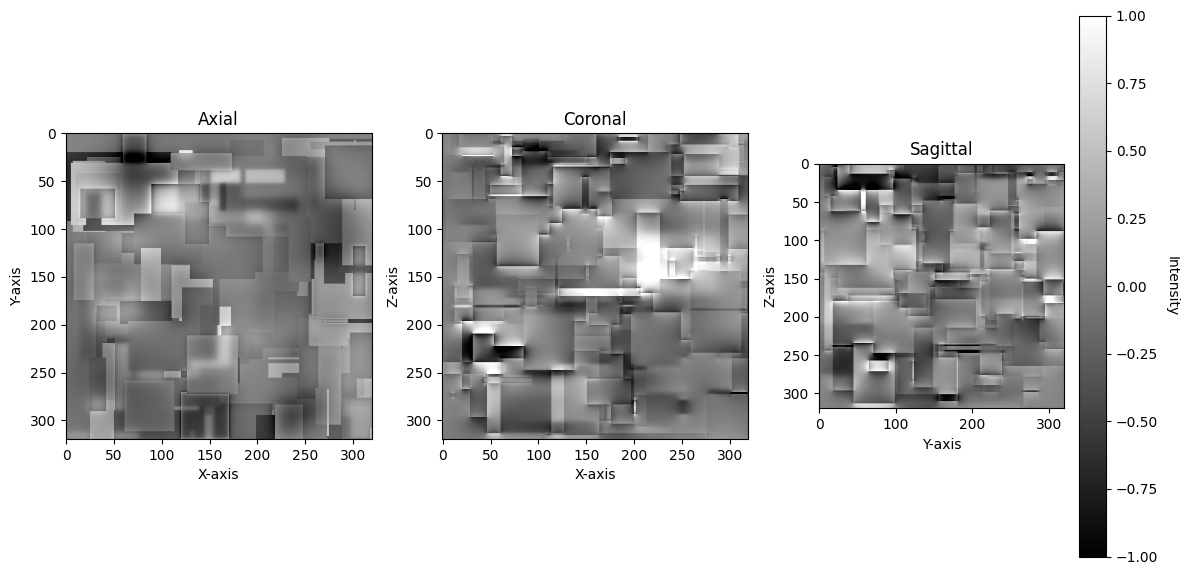

In [9]:
# Simulate tissue phase with padding
simulated_tissue_phase_full = simulate_mri_tissue_phase(sim_gt_full)
view_slices_3d(simulated_tissue_phase_full, slice_nbr=100, vmin=-1, vmax=1)

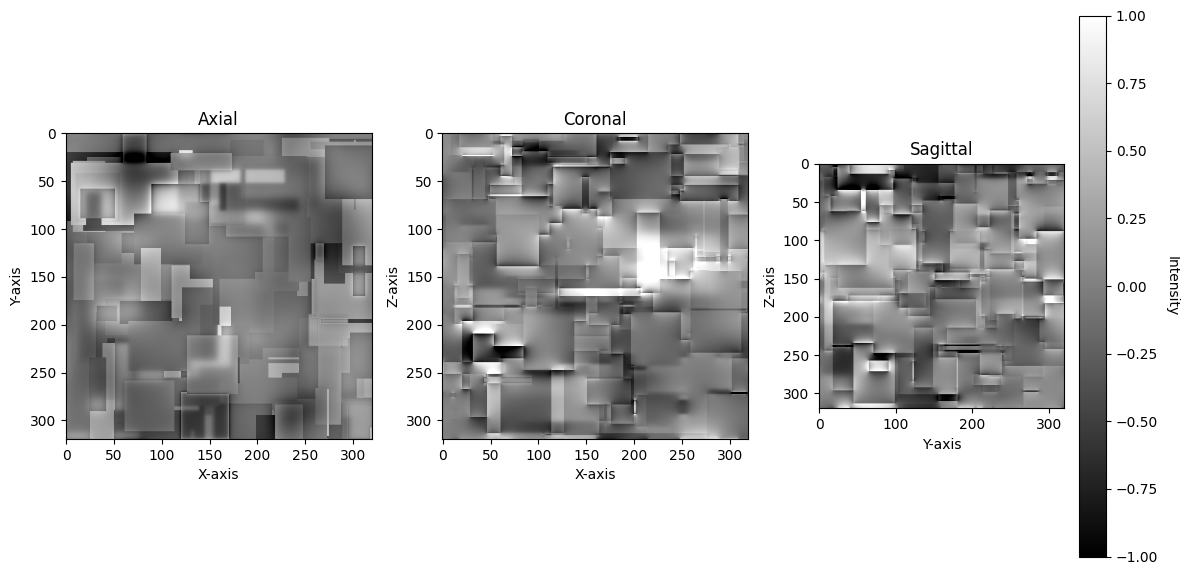

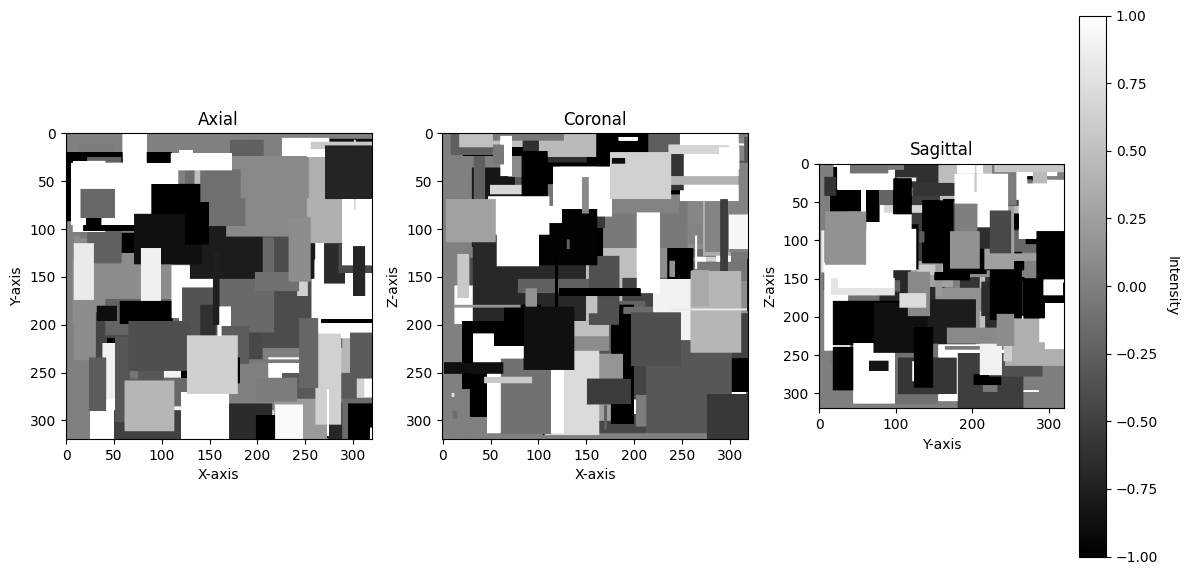

In [10]:
# Simulate tissue phase without padding
simulated_tissue_phase = simulate_mri_tissue_phase_no_padding(sim_gt_full)
view_slices_3d(simulated_tissue_phase, slice_nbr=100, vmin=-1, vmax=1)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

#### Training a model to invert the dipole convolution 

###### Prepare patches for training

In [11]:
total_patches = 500
training_dim = 64

# Split patches to train from our simulations in ground truth and forward
simulation_gt_patches = np.zeros((total_patches, training_dim, training_dim, training_dim))
simulation_fw_patches = np.zeros((total_patches, training_dim, training_dim, training_dim))


for patch_idx in range(total_patches):
  simulation_gt_patches[patch_idx, :, :, :], simulation_fw_patches[patch_idx, :, :, :] = create_batch(training_dim, patch_idx,sim_gt_full,simulated_tissue_phase)


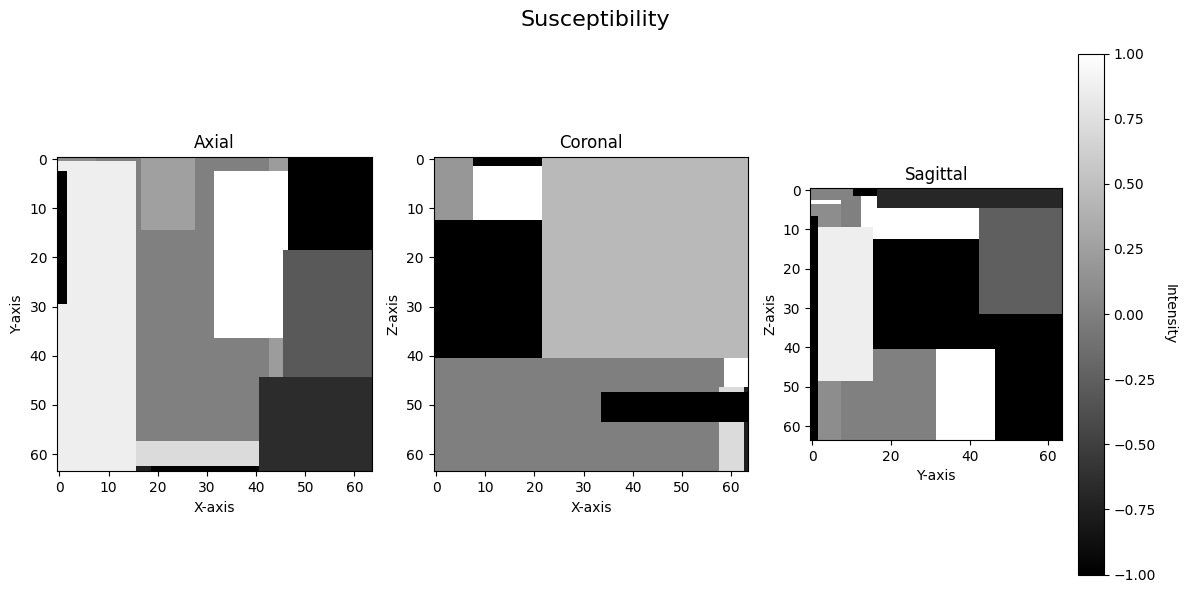

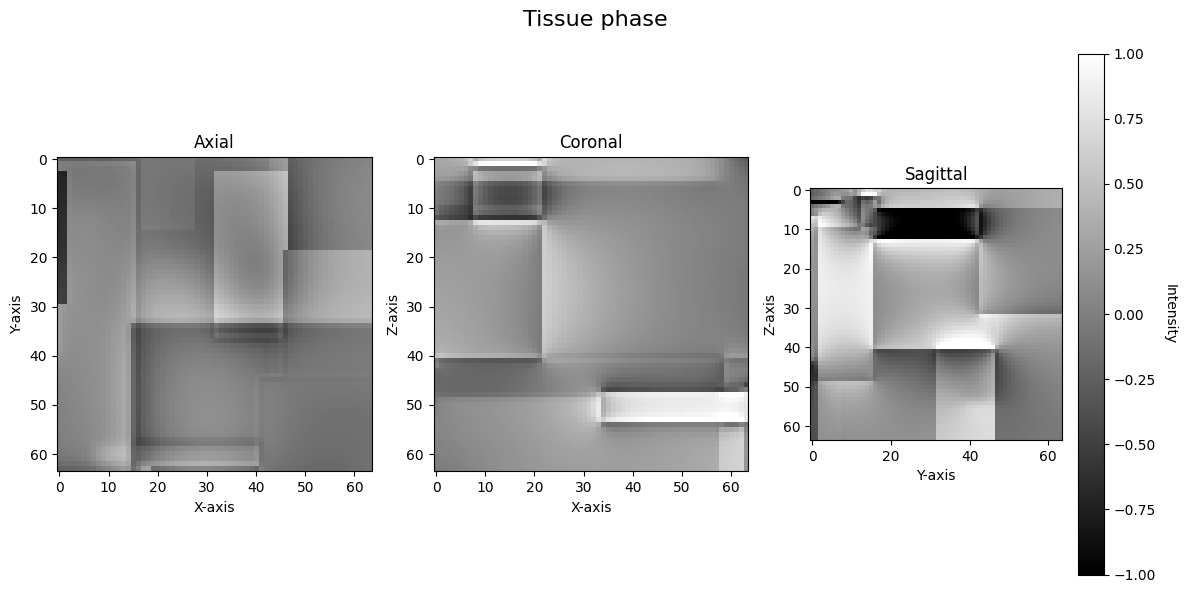

In [12]:
patch_idx = 40
view_slices_3d(simulation_gt_patches[patch_idx, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Susceptibility')
view_slices_3d(simulation_fw_patches[patch_idx, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Tissue phase')

##### Building architectures


In [13]:
# Print TensorFlow version
print(tf.__version__)

# Check GPU device availability
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('Running without GPU acceleration.')

2.12.0
Found GPU at: /device:GPU:0


###### Utils for architectures

In [14]:
# Utils function to construct the model

def downsample(filters, kernel_size, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.LeakyReLU())

    return block


def upsample(filters, kernel_size, apply_dropout=False, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        block.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        block.add(tf.keras.layers.Dropout(0.6))
    block.add(tf.keras.layers.ReLU())

    return block



class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}:")
        print(f"  - Loss: {logs['loss']:.4f}")
        print(f"  - Mean Squared Error: {logs['mse']:.4f}")


In [15]:
# Testing downsample and upsample functions
inp = simulation_fw_patches[0,:,:,:]
print(f"Origianl shape in fw_pathces: {inp.shape}")
inp = tf.expand_dims(inp,0)
print(f"Expanding shape in fw_pathces first position: {inp.shape}")
inp = tf.expand_dims(inp,4)
print(f"Expanding shape in fw_pathces last position: {inp.shape}")

# Downsample
#(batch,x,y,z,channel)
down_sample = downsample(filters=8, kernel_size=4)
reduction = down_sample(inp)
print(f"Shape in fw_pathces after downsample: {reduction.shape}")

#Upsample
up_sample = upsample(filters=8, kernel_size=4)
expansion = up_sample(reduction)
print(f"Shape in fw_pathces after upsample: {expansion.shape}")

Origianl shape in fw_pathces: (64, 64, 64)
Expanding shape in fw_pathces first position: (1, 64, 64, 64)
Expanding shape in fw_pathces last position: (1, 64, 64, 64, 1)
Shape in fw_pathces after downsample: (1, 32, 32, 32, 8)
Shape in fw_pathces after upsample: (1, 64, 64, 64, 8)


###### ***Parameters***

In [16]:
EPOCHS = 500
PERIOD_TO_STORE = 25
OUTPUT_CHANNELS = 1

###### ***Model 1 - Architecture***

In [17]:
def model_1(filter_base=32, kernel_size=3):
    # Define the downsample blocks
    down_stack = [
        downsample(filter_base, kernel_size, apply_batch_norm=False),  # (base, 32, 32, 32, 64)
        downsample(filter_base * 2, kernel_size),                      # (base, 16, 16, 16, 128)
        downsample(filter_base * 3, kernel_size),                      # (base, 8, 8, 8, 256)
        downsample(filter_base * 4, kernel_size),                      # (base, 4, 4, 4, 512)
        downsample(filter_base * 5, kernel_size),                      # (base, 2, 2, 2, 1024)
    ]

    # Define the upsample blocks
    up_stack = [
        upsample(filter_base * 5, kernel_size, apply_dropout=True),     # (base, 4, 4, 4, 1024)
        upsample(filter_base * 4, kernel_size, apply_dropout=True),     # (base, 8, 8, 8, 512)
        upsample(filter_base * 3, kernel_size, apply_dropout=True),     # (base, 16, 16, 16, 256)
        upsample(filter_base * 2, kernel_size, apply_dropout=True),     # (base, 32, 32, 32, 128)
    ]

    # Define the final layer
    initializer = tf.random_normal_initializer(0., 0.02)
    final_layer = tf.keras.layers.Conv3DTranspose(OUTPUT_CHANNELS,
                                                  kernel_size,
                                                  strides=2,
                                                  padding='same',
                                                  kernel_initializer=initializer,
                                                  activation='tanh')  # (base, 256, 256, 3)

    concatenate = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # Reverse the skips for correct order in upsampling

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])

    x = final_layer(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
unet_model1 = model_1()

# Define the learning rate schedule
initial_learning_rate = 0.003
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  # Adjust this value based on your dataset and training requirements
    decay_rate=0.96  # Adjust this value based on your dataset and training requirements
)

# Create the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer
unet_model1.compile(loss=losses.mean_squared_error, optimizer=optimizer)
unet_model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 sequential_2 (Sequential)      (None, None, None,   864         ['input_1[0][0]']                
                                None, 32)                                                         
                                                                                                  
 sequential_3 (Sequential)      (None, None, None,   55552       ['sequential_2[0][0]']           
                                None, 64)                                                     

###### ***Model 1 - Using the model to predict without training***

Shape of testing data: (1, 64, 64, 64, 1)
1/1 [==============================] - 1s 518ms/step
Shape of testing data: (1, 64, 64, 64, 1)


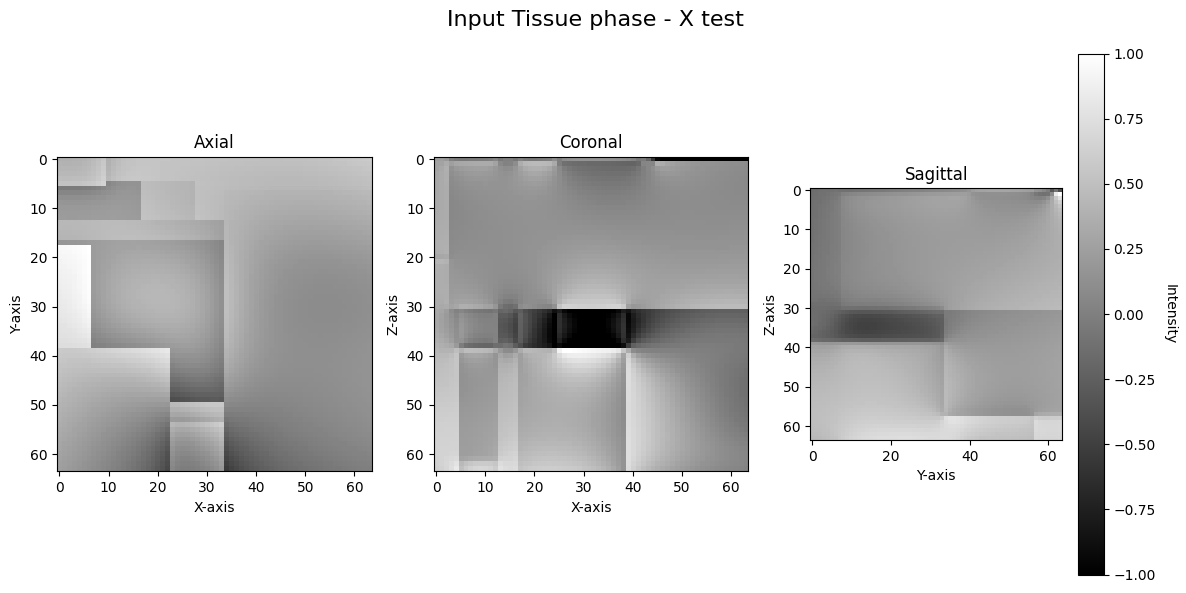

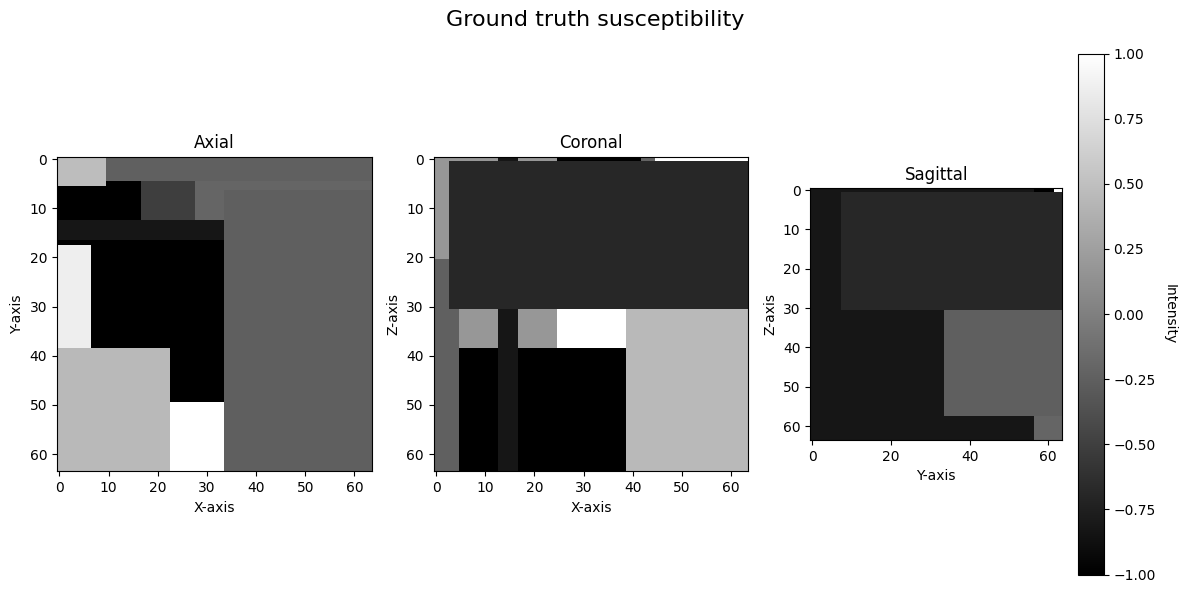

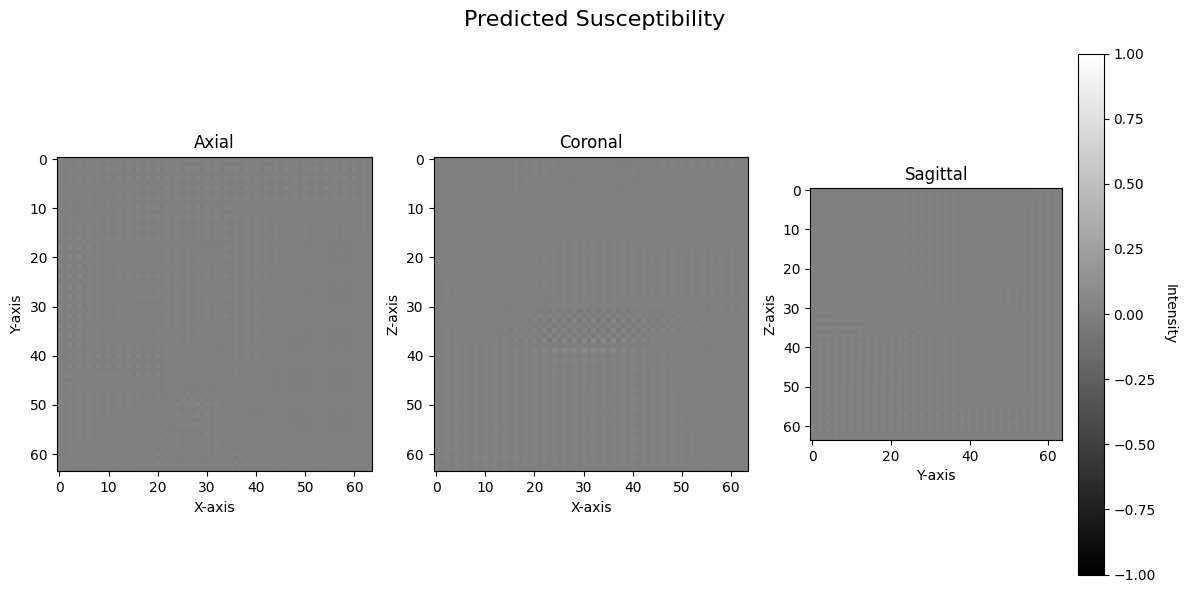

In [19]:
test_patch_nbr = 10
X_test = simulation_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(f"Shape of testing data: {X_test.shape}")

# Getting prediction from model without training
y_pred = unet_model1.predict(X_test)
print(f"Shape of testing data: {X_test.shape}")
view_slices_3d(X_test[0, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Input Tissue phase - X test')
view_slices_3d(simulation_gt_patches[test_patch_nbr, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Ground truth susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


###### ***Model 1 - Trainning the model***

In [ ]:
# Directories to store the checkpoints created
checkpoint_path_1 = "checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path_1)

# Callback to save checkpoints
cp_callback = ModelCheckpoint(
    checkpoint_path_1,
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)


early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1
)

# Split data into training and validation sets
validation_split = 0.2
split_index = int(len(simulation_fw_patches) * (1 - validation_split))
train_images = tf.expand_dims(simulation_fw_patches[:split_index], 4)
train_labels = tf.expand_dims(simulation_gt_patches[:split_index], 4)
val_images = tf.expand_dims(simulation_fw_patches[split_index:], 4)
val_labels = tf.expand_dims(simulation_gt_patches[split_index:], 4)


# Train the model with validation data
loss_history_1 = []
with tqdm(total=EPOCHS, desc="Training") as pbar:
    for epoch in range(EPOCHS):
        pbar.set_postfix({'Epoch': epoch+1})
        history_1 = unet_model1.fit(
            train_images,
            train_labels,
            epochs=1,
            batch_size=15,
            shuffle=True,
            validation_data=(val_images, val_labels),
            callbacks=[cp_callback, early_stopping_callback]
        )
        
        loss_history_1.append(history_1.history["loss"][0])
        
        # Clear memory after each epoch
        del history_1
        tf.keras.backend.clear_session()
        
        pbar.update(1)

with open('loss_history_1.pickle', 'wb') as f:
    pickle.dump([loss_history_1, len(loss_history_1)], f)


Training:   0%|          | 0/500 [00:00<?, ?it/s, Epoch=1]

27/27 [==============================] - ETA: 0s - loss: 0.8722
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 15s 240ms/step - loss: 0.8722 - val_loss: 1.4661


Training:   0%|          | 1/500 [00:16<2:13:45, 16.08s/it, Epoch=2]

27/27 [==============================] - ETA: 0s - loss: 0.5986
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 170ms/step - loss: 0.5986 - val_loss: 1.0809


Training:   0%|          | 2/500 [00:21<1:22:48,  9.98s/it, Epoch=3]

27/27 [==============================] - ETA: 0s - loss: 0.4914
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 173ms/step - loss: 0.4914 - val_loss: 0.7448


Training:   1%|          | 3/500 [00:26<1:04:34,  7.80s/it, Epoch=4]

27/27 [==============================] - ETA: 0s - loss: 0.4389
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 172ms/step - loss: 0.4389 - val_loss: 0.5991


Training:   1%|          | 4/500 [00:32<58:10,  7.04s/it, Epoch=5]

27/27 [==============================] - ETA: 0s - loss: 0.3837
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 170ms/step - loss: 0.3837 - val_loss: 0.5008


Training:   1%|          | 5/500 [00:38<53:46,  6.52s/it, Epoch=6]

27/27 [==============================] - ETA: 0s - loss: 0.3422
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 188ms/step - loss: 0.3422 - val_loss: 0.4816


Training:   1%|          | 6/500 [00:44<51:18,  6.23s/it, Epoch=7]

27/27 [==============================] - ETA: 0s - loss: 0.3148
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 171ms/step - loss: 0.3148 - val_loss: 0.3930


Training:   1%|▏         | 7/500 [00:49<48:16,  5.87s/it, Epoch=8]

27/27 [==============================] - ETA: 0s - loss: 0.2859
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 190ms/step - loss: 0.2859 - val_loss: 0.4047


Training:   2%|▏         | 8/500 [00:54<47:35,  5.80s/it, Epoch=9]

27/27 [==============================] - ETA: 0s - loss: 0.2716
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 173ms/step - loss: 0.2716 - val_loss: 0.3514


Training:   2%|▏         | 9/500 [01:00<46:59,  5.74s/it, Epoch=10]

27/27 [==============================] - ETA: 0s - loss: 0.2656
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 191ms/step - loss: 0.2656 - val_loss: 0.3523


Training:   2%|▏         | 10/500 [01:06<46:39,  5.71s/it, Epoch=11]

27/27 [==============================] - ETA: 0s - loss: 0.2497
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 172ms/step - loss: 0.2497 - val_loss: 0.2950


Training:   2%|▏         | 11/500 [01:11<46:21,  5.69s/it, Epoch=12]

27/27 [==============================] - ETA: 0s - loss: 0.2426
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 179ms/step - loss: 0.2426 - val_loss: 0.3024


Training:   2%|▏         | 12/500 [01:17<46:02,  5.66s/it, Epoch=13]

27/27 [==============================] - ETA: 0s - loss: 0.2306
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 176ms/step - loss: 0.2306 - val_loss: 0.3055


Training:   3%|▎         | 13/500 [01:22<45:44,  5.64s/it, Epoch=14]

27/27 [==============================] - ETA: 0s - loss: 0.2270
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 176ms/step - loss: 0.2270 - val_loss: 0.2988


Training:   3%|▎         | 14/500 [01:28<45:31,  5.62s/it, Epoch=15]

27/27 [==============================] - ETA: 0s - loss: 0.2356
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 178ms/step - loss: 0.2356 - val_loss: 0.2752


Training:   3%|▎         | 15/500 [01:34<46:08,  5.71s/it, Epoch=16]

27/27 [==============================] - ETA: 0s - loss: 0.2324
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 174ms/step - loss: 0.2324 - val_loss: 0.2797


Training:   3%|▎         | 16/500 [01:39<44:48,  5.55s/it, Epoch=17]

27/27 [==============================] - ETA: 0s - loss: 0.2183
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 183ms/step - loss: 0.2183 - val_loss: 0.2765


Training:   3%|▎         | 17/500 [01:45<44:25,  5.52s/it, Epoch=18]

27/27 [==============================] - ETA: 0s - loss: 0.2181
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 176ms/step - loss: 0.2181 - val_loss: 0.2666


Training:   4%|▎         | 18/500 [01:50<43:42,  5.44s/it, Epoch=19]

27/27 [==============================] - ETA: 0s - loss: 0.2149
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 7s 229ms/step - loss: 0.2149 - val_loss: 0.2694


Training:   4%|▍         | 19/500 [01:57<46:42,  5.83s/it, Epoch=20]

27/27 [==============================] - ETA: 0s - loss: 0.2095
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 208ms/step - loss: 0.2095 - val_loss: 0.2648


Training:   4%|▍         | 20/500 [02:03<48:21,  6.05s/it, Epoch=21]

27/27 [==============================] - ETA: 0s - loss: 0.2037
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 7s 210ms/step - loss: 0.2037 - val_loss: 0.2746


Training:   4%|▍         | 21/500 [02:15<1:01:15,  7.67s/it, Epoch=22]

27/27 [==============================] - ETA: 0s - loss: 0.2031
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 187ms/step - loss: 0.2031 - val_loss: 0.2624


Training:   4%|▍         | 22/500 [02:25<1:08:22,  8.58s/it, Epoch=23]

27/27 [==============================] - ETA: 0s - loss: 0.2077
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 177ms/step - loss: 0.2077 - val_loss: 0.2728


Training:   5%|▍         | 23/500 [02:31<1:00:32,  7.61s/it, Epoch=24]

27/27 [==============================] - ETA: 0s - loss: 0.2055
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 182ms/step - loss: 0.2055 - val_loss: 0.2581


Training:   5%|▍         | 24/500 [02:36<55:50,  7.04s/it, Epoch=25]

27/27 [==============================] - ETA: 0s - loss: 0.2011
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 190ms/step - loss: 0.2011 - val_loss: 0.2558


Training:   5%|▌         | 25/500 [02:47<1:04:28,  8.14s/it, Epoch=26]

27/27 [==============================] - ETA: 0s - loss: 0.1956
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 177ms/step - loss: 0.1956 - val_loss: 0.2544


Training:   5%|▌         | 26/500 [02:53<57:51,  7.32s/it, Epoch=27]

27/27 [==============================] - ETA: 0s - loss: 0.2003
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 181ms/step - loss: 0.2003 - val_loss: 0.2512


Training:   5%|▌         | 27/500 [02:58<53:07,  6.74s/it, Epoch=28]

27/27 [==============================] - ETA: 0s - loss: 0.1954
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 179ms/step - loss: 0.1954 - val_loss: 0.2408


Training:   6%|▌         | 28/500 [03:03<50:18,  6.39s/it, Epoch=29]

27/27 [==============================] - ETA: 0s - loss: 0.2026
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 200ms/step - loss: 0.2026 - val_loss: 0.2546


Training:   6%|▌         | 29/500 [03:14<1:00:23,  7.69s/it, Epoch=30]

27/27 [==============================] - ETA: 0s - loss: 0.1989
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 179ms/step - loss: 0.1989 - val_loss: 0.2570


Training:   6%|▌         | 30/500 [03:20<54:55,  7.01s/it, Epoch=31]

27/27 [==============================] - ETA: 0s - loss: 0.1945
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 182ms/step - loss: 0.1945 - val_loss: 0.2461


Training:   6%|▌         | 31/500 [03:25<51:46,  6.62s/it, Epoch=32]

27/27 [==============================] - ETA: 0s - loss: 0.1922
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 178ms/step - loss: 0.1922 - val_loss: 0.2500


Training:   6%|▋         | 32/500 [03:31<48:49,  6.26s/it, Epoch=33]

27/27 [==============================] - ETA: 0s - loss: 0.1915
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 183ms/step - loss: 0.1915 - val_loss: 0.2438


Training:   7%|▋         | 33/500 [03:36<46:49,  6.02s/it, Epoch=34]

27/27 [==============================] - ETA: 0s - loss: 0.1916
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 176ms/step - loss: 0.1916 - val_loss: 0.2478


Training:   7%|▋         | 34/500 [03:42<45:45,  5.89s/it, Epoch=35]

27/27 [==============================] - ETA: 0s - loss: 0.1941
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 190ms/step - loss: 0.1941 - val_loss: 0.2603


Training:   7%|▋         | 35/500 [03:53<56:51,  7.34s/it, Epoch=36]

27/27 [==============================] - ETA: 0s - loss: 0.1946
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 188ms/step - loss: 0.1946 - val_loss: 0.2442


Training:   7%|▋         | 36/500 [04:03<1:04:36,  8.35s/it, Epoch=37]

27/27 [==============================] - ETA: 0s - loss: 0.1902
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 179ms/step - loss: 0.1902 - val_loss: 0.2458


Training:   7%|▋         | 37/500 [04:09<57:40,  7.48s/it, Epoch=38]

27/27 [==============================] - ETA: 0s - loss: 0.1884
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 183ms/step - loss: 0.1884 - val_loss: 0.2501


Training:   8%|▊         | 38/500 [04:15<53:50,  6.99s/it, Epoch=39]

27/27 [==============================] - ETA: 0s - loss: 0.1898
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 182ms/step - loss: 0.1898 - val_loss: 0.2511


Training:   8%|▊         | 39/500 [04:20<50:29,  6.57s/it, Epoch=40]

27/27 [==============================] - ETA: 0s - loss: 0.1897
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 187ms/step - loss: 0.1897 - val_loss: 0.2547


Training:   8%|▊         | 40/500 [04:26<48:09,  6.28s/it, Epoch=41]

27/27 [==============================] - ETA: 0s - loss: 0.1900
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 182ms/step - loss: 0.1900 - val_loss: 0.2462


Training:   8%|▊         | 41/500 [04:31<46:29,  6.08s/it, Epoch=42]

27/27 [==============================] - ETA: 0s - loss: 0.1905
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 185ms/step - loss: 0.1905 - val_loss: 0.2452


Training:   8%|▊         | 42/500 [04:37<45:03,  5.90s/it, Epoch=43]

27/27 [==============================] - ETA: 0s - loss: 0.1869
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 179ms/step - loss: 0.1869 - val_loss: 0.2468


Training:   9%|▊         | 43/500 [04:42<43:39,  5.73s/it, Epoch=44]

27/27 [==============================] - ETA: 0s - loss: 0.1921
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 191ms/step - loss: 0.1921 - val_loss: 0.2488


Training:   9%|▉         | 44/500 [04:48<43:20,  5.70s/it, Epoch=45]

27/27 [==============================] - ETA: 0s - loss: 0.1871
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 177ms/step - loss: 0.1871 - val_loss: 0.2489


Training:   9%|▉         | 45/500 [04:54<43:40,  5.76s/it, Epoch=46]

27/27 [==============================] - ETA: 0s - loss: 0.1857
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 183ms/step - loss: 0.1857 - val_loss: 0.2413


Training:   9%|▉         | 46/500 [04:59<42:50,  5.66s/it, Epoch=47]

27/27 [==============================] - ETA: 0s - loss: 0.1830
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 182ms/step - loss: 0.1830 - val_loss: 0.2516


Training:   9%|▉         | 47/500 [05:05<43:28,  5.76s/it, Epoch=48]

27/27 [==============================] - ETA: 0s - loss: 0.1854
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 180ms/step - loss: 0.1854 - val_loss: 0.2416


Training:  10%|▉         | 48/500 [05:10<42:31,  5.65s/it, Epoch=49]

27/27 [==============================] - ETA: 0s - loss: 0.1865
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 184ms/step - loss: 0.1865 - val_loss: 0.2520


Training:  10%|▉         | 49/500 [05:16<42:02,  5.59s/it, Epoch=50]

27/27 [==============================] - ETA: 0s - loss: 0.1846
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 178ms/step - loss: 0.1846 - val_loss: 0.2461


Training:  10%|█         | 50/500 [05:21<41:15,  5.50s/it, Epoch=51]

27/27 [==============================] - ETA: 0s - loss: 0.1813
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 184ms/step - loss: 0.1813 - val_loss: 0.2474


Training:  10%|█         | 51/500 [05:27<41:25,  5.54s/it, Epoch=52]

27/27 [==============================] - ETA: 0s - loss: 0.1810
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 182ms/step - loss: 0.1810 - val_loss: 0.2414


Training:  10%|█         | 52/500 [05:32<41:27,  5.55s/it, Epoch=53]

27/27 [==============================] - ETA: 0s - loss: 0.1815
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 191ms/step - loss: 0.1815 - val_loss: 0.2389


Training:  11%|█         | 53/500 [05:43<52:59,  7.11s/it, Epoch=54]

27/27 [==============================] - ETA: 0s - loss: 0.1783
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 182ms/step - loss: 0.1783 - val_loss: 0.2394


Training:  11%|█         | 54/500 [05:49<49:31,  6.66s/it, Epoch=55]

27/27 [==============================] - ETA: 0s - loss: 0.1817
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 179ms/step - loss: 0.1817 - val_loss: 0.2452


Training:  11%|█         | 55/500 [05:54<47:10,  6.36s/it, Epoch=56]

27/27 [==============================] - ETA: 0s - loss: 0.1781
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 180ms/step - loss: 0.1781 - val_loss: 0.2419


Training:  11%|█         | 56/500 [06:00<45:23,  6.13s/it, Epoch=57]

27/27 [==============================] - ETA: 0s - loss: 0.1795
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 183ms/step - loss: 0.1795 - val_loss: 0.2440


Training:  11%|█▏        | 57/500 [06:06<44:05,  5.97s/it, Epoch=58]

27/27 [==============================] - ETA: 0s - loss: 0.1797
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 180ms/step - loss: 0.1797 - val_loss: 0.2461


Training:  12%|█▏        | 58/500 [06:11<43:09,  5.86s/it, Epoch=59]

27/27 [==============================] - ETA: 0s - loss: 0.1825
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 184ms/step - loss: 0.1825 - val_loss: 0.2432


Training:  12%|█▏        | 59/500 [06:17<42:27,  5.78s/it, Epoch=60]

27/27 [==============================] - ETA: 0s - loss: 0.1823
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 177ms/step - loss: 0.1823 - val_loss: 0.2474


Training:  12%|█▏        | 60/500 [06:22<41:59,  5.73s/it, Epoch=61]

27/27 [==============================] - ETA: 0s - loss: 0.1850
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 190ms/step - loss: 0.1850 - val_loss: 0.2499


Training:  12%|█▏        | 61/500 [06:28<41:41,  5.70s/it, Epoch=62]

27/27 [==============================] - ETA: 0s - loss: 0.1854
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 180ms/step - loss: 0.1854 - val_loss: 0.2548


Training:  12%|█▏        | 62/500 [06:34<41:27,  5.68s/it, Epoch=63]

27/27 [==============================] - ETA: 0s - loss: 0.1828
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 190ms/step - loss: 0.1828 - val_loss: 0.2645


Training:  13%|█▎        | 63/500 [06:39<41:17,  5.67s/it, Epoch=64]

27/27 [==============================] - ETA: 0s - loss: 0.1792
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 179ms/step - loss: 0.1792 - val_loss: 0.2406


Training:  13%|█▎        | 64/500 [06:45<41:44,  5.75s/it, Epoch=65]

27/27 [==============================] - ETA: 0s - loss: 0.1780
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 191ms/step - loss: 0.1780 - val_loss: 0.2411


Training:  13%|█▎        | 65/500 [06:51<41:38,  5.74s/it, Epoch=66]

27/27 [==============================] - ETA: 0s - loss: 0.1784
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 178ms/step - loss: 0.1784 - val_loss: 0.2484


Training:  13%|█▎        | 66/500 [06:57<41:15,  5.70s/it, Epoch=67]

27/27 [==============================] - ETA: 0s - loss: 0.1789
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 179ms/step - loss: 0.1789 - val_loss: 0.2505


Training:  13%|█▎        | 67/500 [07:02<40:55,  5.67s/it, Epoch=68]

27/27 [==============================] - ETA: 0s - loss: 0.1767
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 183ms/step - loss: 0.1767 - val_loss: 0.2425


Training:  14%|█▎        | 68/500 [07:08<40:52,  5.68s/it, Epoch=69]

27/27 [==============================] - ETA: 0s - loss: 0.1801
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 180ms/step - loss: 0.1801 - val_loss: 0.2469


Training:  14%|█▍        | 69/500 [07:14<40:39,  5.66s/it, Epoch=70]

27/27 [==============================] - ETA: 0s - loss: 0.1775
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 183ms/step - loss: 0.1775 - val_loss: 0.2454


Training:  14%|█▍        | 70/500 [07:19<40:25,  5.64s/it, Epoch=71]

27/27 [==============================] - ETA: 0s - loss: 0.1765
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 188ms/step - loss: 0.1765 - val_loss: 0.2437


Training:  14%|█▍        | 71/500 [07:25<40:17,  5.63s/it, Epoch=72]

27/27 [==============================] - ETA: 0s - loss: 0.1773
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 185ms/step - loss: 0.1773 - val_loss: 0.2462


Training:  14%|█▍        | 72/500 [07:30<40:08,  5.63s/it, Epoch=73]

27/27 [==============================] - ETA: 0s - loss: 0.1817
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 179ms/step - loss: 0.1817 - val_loss: 0.2514


Training:  15%|█▍        | 73/500 [07:36<39:59,  5.62s/it, Epoch=74]

27/27 [==============================] - ETA: 0s - loss: 0.1781
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 197ms/step - loss: 0.1781 - val_loss: 0.2486


Training:  15%|█▍        | 74/500 [07:42<40:22,  5.69s/it, Epoch=75]

27/27 [==============================] - ETA: 0s - loss: 0.1891
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 176ms/step - loss: 0.1891 - val_loss: 0.2526


Training:  15%|█▌        | 75/500 [07:47<39:33,  5.59s/it, Epoch=76]

27/27 [==============================] - ETA: 0s - loss: 0.1835
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 181ms/step - loss: 0.1835 - val_loss: 0.2456


Training:  15%|█▌        | 76/500 [07:53<39:30,  5.59s/it, Epoch=77]

27/27 [==============================] - ETA: 0s - loss: 0.1769
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 177ms/step - loss: 0.1769 - val_loss: 0.2362


Training:  15%|█▌        | 77/500 [07:59<40:01,  5.68s/it, Epoch=78]

27/27 [==============================] - ETA: 0s - loss: 0.1749
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 178ms/step - loss: 0.1749 - val_loss: 0.2419


Training:  16%|█▌        | 78/500 [08:04<39:08,  5.57s/it, Epoch=79]

27/27 [==============================] - ETA: 0s - loss: 0.1777
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 182ms/step - loss: 0.1777 - val_loss: 0.2437


Training:  16%|█▌        | 79/500 [08:10<39:15,  5.60s/it, Epoch=80]

27/27 [==============================] - ETA: 0s - loss: 0.1775
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 177ms/step - loss: 0.1775 - val_loss: 0.2448


Training:  16%|█▌        | 80/500 [08:15<38:32,  5.51s/it, Epoch=81]

27/27 [==============================] - ETA: 0s - loss: 0.1752
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 184ms/step - loss: 0.1752 - val_loss: 0.2386


Training:  16%|█▌        | 81/500 [08:20<38:23,  5.50s/it, Epoch=82]

27/27 [==============================] - ETA: 0s - loss: 0.1752
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 178ms/step - loss: 0.1752 - val_loss: 0.2431


Training:  16%|█▋        | 82/500 [08:26<38:31,  5.53s/it, Epoch=83]

27/27 [==============================] - ETA: 0s - loss: 0.1740
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 193ms/step - loss: 0.1740 - val_loss: 0.2388


Training:  17%|█▋        | 83/500 [08:37<49:18,  7.09s/it, Epoch=84]

27/27 [==============================] - ETA: 0s - loss: 0.1725
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 183ms/step - loss: 0.1725 - val_loss: 0.2399


Training:  17%|█▋        | 84/500 [08:42<45:55,  6.62s/it, Epoch=85]

27/27 [==============================] - ETA: 0s - loss: 0.1735
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 178ms/step - loss: 0.1735 - val_loss: 0.2458


Training:  17%|█▋        | 85/500 [08:48<44:16,  6.40s/it, Epoch=86]

27/27 [==============================] - ETA: 0s - loss: 0.1731
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 5s 177ms/step - loss: 0.1731 - val_loss: 0.2430


Training:  17%|█▋        | 86/500 [08:53<41:54,  6.07s/it, Epoch=87]

27/27 [==============================] - ETA: 0s - loss: 0.1725
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 193ms/step - loss: 0.1725 - val_loss: 0.2475


Training:  17%|█▋        | 87/500 [09:04<51:30,  7.48s/it, Epoch=88]

27/27 [==============================] - ETA: 0s - loss: 0.1715
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 185ms/step - loss: 0.1715 - val_loss: 0.2431


Training:  18%|█▊        | 88/500 [09:10<48:19,  7.04s/it, Epoch=89]

27/27 [==============================] - ETA: 0s - loss: 0.1723
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 179ms/step - loss: 0.1723 - val_loss: 0.2425


Training:  18%|█▊        | 89/500 [09:16<45:21,  6.62s/it, Epoch=90]

27/27 [==============================] - ETA: 0s - loss: 0.1730
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 189ms/step - loss: 0.1730 - val_loss: 0.2509


Training:  18%|█▊        | 90/500 [09:27<54:10,  7.93s/it, Epoch=91]

27/27 [==============================] - ETA: 0s - loss: 0.1706
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
27/27 [==============================] - 6s 190ms/step - loss: 0.1706 - val_loss: 0.2402


In [ ]:
import matplotlib.pyplot as plt

# Load stored data
checkpoint_path1 = "checkpoints1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
print(latest1)
model1.load_weights(latest1)

with open('loss_history1.pickle', 'rb') as f:
    [loss_history1, epochs_train1] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax
  
fig, ax = get_figure()

epochs = np.arange(epochs_train1) + 1
ax.plot(epochs, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(epochs, val_loss_history1, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

plt.show()
